<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Text Analytics - Assignment 2
COMPETITION TASK: 

+ Learn the classification model for training set with 5 categorical data from ['business', 'entertainment', 'politics', 'sport', 'tech'].

+ Apply learned model to get the labels for "testdata.csv"

## Team Members: 
Laura Brierton - 15317451, Clodagh Lalor - 13354426, Jeremy Schiff - student#, Peter Concannon - student#

============================================================================================================================

In [12]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Pre-Processing

## Step 1: Import packages

In [13]:
import pandas as pd
import numpy as np
import re
import nltk, json
from wordcloud import WordCloud
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import math

In [14]:
## we started by importing our datasets
raw_trainset = pd.read_csv('trainingset.csv',sep='^',header=0)
raw_testdata = pd.read_csv('testdata.csv',sep='^',header=0)
raw_trainset.head()

,content,category
0,French boss to leave EADS The French co-head o...,business
1,"Gamers could drive high-definition TV, films, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,politics
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment
4,Tautou 'to star in Da Vinci film' French actre...,entertainment


## Step 2: Extract Tokens

In [15]:
## Define the Function to convert raw text to tokens
def convert_tokens(rawtext, verbose=False):
    # First: Tokenization
    # start by removing hyphens to allow for better tokenization
    rawtext = rawtext.replace('-', ' ')
    pattern = r'\w+'
    tokenizer = RegexpTokenizer(pattern)
    token_words = tokenizer.tokenize(rawtext)
    if (verbose):
        print('Tokens:' + str(token_words[0:10]))
    
    # Second: Decapitalization 
    decap_token_words = [word.lower() for word in token_words]
    if (verbose):
        print('Decapitalized Tokens:' + str(decap_token_words[0:10]))
    
    # Third: Remove stop words
    json_data=open('stopwords.json', encoding="utf8").read()
    stopwords_json = json.loads(json_data)
    stopwords_json_en = set(stopwords_json['en'])
    stopwords_nltk_en = set(stopwords.words('english'))
    # Combine the stopwords. Its a lot longer so I'm not printing it out...
    stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en)

    
    rmsw_token_words = ([word for word in decap_token_words if word.lower() not in stoplist_combined])
    if (verbose):
        print('Stopwords removed:' + str(rmsw_token_words[0:20]))
    
    ## Fouth: remove CAP words
    rmcap_token_words =[]
    for word in rmsw_token_words:
        if word.isupper():
            rmcap_token_words.append(word.title())
        else:
            rmcap_token_words.append(word)
    if (verbose):
        print('CAPITALIZED removed:' + str(rmcap_token_words[0:20]))
        
     ## Fifth : Remove salutation
    salutation = ['mr','mrs','mss','dr','phd','prof','rev', 'professor']
    rmsalu_token_words = ([word for word in rmcap_token_words if word.lower() not in salutation])
    if (verbose):
        print('Salutation removed:' + str(rmsalu_token_words[0:20]))
        
     ## Sixth: Remove words containing numbers
    rmnb_token_words = ([word for word in rmsalu_token_words if not re.search(r"\d+", word)])
    if (verbose):
        print('Number removed: ' + str(rmnb_token_words[0:20]))
        
    ## define transfer tag function:
    def transfer_tag(treebank_tag):
        if treebank_tag.startswith('j' or 'J'):
            return 'a'
        elif treebank_tag.startswith('v' or 'V'):
            return 'v'
        elif treebank_tag.startswith('n' or 'N'):
            return 'n'
        elif treebank_tag.startswith('r' or 'R'):
            return 'r'
        else:
            # As default pos in lemmatization is Noun
            return 'n'
    
    ## Seventh: Lemmatization - this is the issue step
    wnl = WordNetLemmatizer()

    lemma_words = []
    for word, tag in nltk.pos_tag(rmnb_token_words):
        firstletter = tag[0].lower() # -> get the first letter of tag and put them decapitalized form
        wtag = transfer_tag(firstletter) # -> extract the word's tag (noun, verb, adverb, adjective)
        if not wtag:
            lemma_words.extend([word])
        ##please note we had to hardcode the following words in due to an error with word net
        elif word == "boss":
            lemma_words.extend([(word)])
        elif word == "gamers":
            lemma_words.extend([("gamer")])
        else:
            lemma_words.extend([wnl.lemmatize(word, wtag)]) # -> get lemma for word with tag
    if (verbose):
        print('Lemmas : ' + str(lemma_words[0:10]))
        
    
    ## RETURN
    return lemma_words

Extract tokens for training set

In [16]:
## we next create a dataframe that contained the content category and bag of words for each document
df_handle = raw_trainset.copy()
df_handle["Tokens"] = df_handle.apply(lambda row: convert_tokens(row["content"]), axis=1)
df_handle.head(10)

,content,category,Tokens
0,French boss to leave EADS The French co-head o...,business,"[french, boss, leave, eads, french, head, euro..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamer, drive, high, definition, tv, film, gam..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aim, ..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres..."
5,Media seek Jackson 'juror' notes Reporters cov...,entertainment,"[medium, seek, jackson, juror, note, reporter,..."
6,Horror film heads US box office A low-budget h...,entertainment,"[horror, film, head, box, office, low, budget,..."
7,Kerr frustrated at victory margin Republic of ...,sport,"[kerr, frustrate, victory, margin, republic, i..."
8,US casino 'tricks' face ban in UK Controversia...,politics,"[casino, trick, face, ban, uk, controversial, ..."
9,Klinsmann issues Lehmann warning Germany coach...,sport,"[klinsmann, issue, lehmann, warn, germany, coa..."


Convert tokens for test set

In [17]:
df_handle_test = raw_testdata.copy()
df_handle_test_onhold = raw_testdata.copy() #on hold until the end of the document
df_handle_test["Tokens"] = df_handle_test.apply(lambda row: convert_tokens(row["content"]), axis=1)
df_handle_test.head(10)

,content,Tokens
0,Eminem secret gig venue revealed Rapper Eminem...,"[eminem, secret, gig, venue, reveal, rapper, e..."
1,Munster Cup tie switched to Spain Munster's He...,"[munster, cup, tie, switch, spain, munster, he..."
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,"[eastwood, baby, scoop, top, oscar, clint, eas..."
3,Spears seeks aborted tour payment Singer Britn...,"[spear, seek, aborted, tour, payment, singer, ..."
4,Gadget show heralds MP3 Christmas Partners of ...,"[gadget, show, herald, christmas, partner, lov..."
5,US Airways staff agree to pay cut A union repr...,"[airways, staff, agree, pay, cut, union, repre..."
6,Blunkett row should end - Blair Prime Minister...,"[blunkett, row, end, blair, prime, minister, t..."
7,Nasdaq planning $100m share sale The owner of ...,"[nasdaq, plan, share, sale, owner, technology,..."
8,Gallery unveils interactive tree A Christmas t...,"[gallery, unveils, interactive, tree, christma..."
9,Escaped prisoner report ordered First Minister...,"[escaped, prisoner, report, order, minister, j..."


We continued the tokenizing process and created entries that contain only the noun or only the adjective tokens.

In [18]:
#Generalization of the extraction
def extract_pos_tokens(tokens, pos):
    # helper for list comprehension
    def is_pos(treebank_tag):
        if treebank_tag.startswith(pos):
            return True
        else:
            return False
    return [word for (word, tag) in nltk.pos_tag(tokens) if is_pos(tag)]

#Specific noun instance
def extract_noun_tokens(tokens):
    # note that this does not include the "or 'n'" component which was both unnecessary and didnt work on my machine
    # furthermore, it does not take noun to be the default
    return extract_pos_tokens(tokens, 'N')
    
#Specific adjective instance
def extract_adj_tokens(tokens):
    # same idea as with nounds - the or 'j' is unneeded
    return extract_pos_tokens(tokens, 'J')

Get noun and adjective tokens for the training set

In [19]:
df_handle["noun_tokens"] = df_handle.apply(lambda row: extract_noun_tokens(row["Tokens"]), axis=1)
df_handle["adjective_tokens"] = df_handle.apply(lambda row: extract_adj_tokens(row["Tokens"]), axis=1)

df_handle.head(10)

,content,category,Tokens,noun_tokens,adjective_tokens
0,French boss to leave EADS The French co-head o...,business,"[french, boss, leave, eads, french, head, euro...","[boss, eads, defence, aerospace, group, statem...","[french, french, european, camus, camus, full,..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamer, drive, high, definition, tv, film, gam...","[gamer, drive, definition, tv, film, game, tim...","[high, gear, high, short, popular, sound, expe..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aim, ...","[pension, strike, talk, talk, aim, strike, pen...","[stalemate, avert, national, public, deputy, p..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh...","[denise, passport, johnny, vaughan, denise, va...","[johnny, saturday, big, plans, bring, real, fo..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres...","[star, da, vinci, film, actress, star, film, a...","[tautou, french, tautou, female, brown, direct..."
5,Media seek Jackson 'juror' notes Reporters cov...,entertainment,"[medium, seek, jackson, juror, note, reporter,...","[medium, seek, jackson, juror, note, reporter,...","[jackson, complete, potential, vital, potentia..."
6,Horror film heads US box office A low-budget h...,entertainment,"[horror, film, head, box, office, low, budget,...","[horror, film, head, box, office, budget, horr...","[low, evil, dead, raimi, top, north, american,..."
7,Kerr frustrated at victory margin Republic of ...,sport,"[kerr, frustrate, victory, margin, republic, i...","[frustrate, victory, margin, ireland, manager,...","[kerr, republic, brian, friendly, win, republi..."
8,US casino 'tricks' face ban in UK Controversia...,politics,"[casino, trick, face, ban, uk, controversial, ...","[casino, face, ban, uk, casino, trick, trade, ...","[trick, uk, controversial, ban, american, resp..."
9,Klinsmann issues Lehmann warning Germany coach...,sport,"[klinsmann, issue, lehmann, warn, germany, coa...","[klinsmann, issue, coach, jurgen, klinsmann, g...","[germany, arsenal, alive, understudy, kahn, ge..."


Get noun and adjective tokens for the training set

In [20]:
df_handle_test["noun_tokens"] = df_handle_test.apply(lambda row: extract_noun_tokens(row["Tokens"]), axis=1)
df_handle_test["adjective_tokens"] = df_handle_test.apply(lambda row: extract_adj_tokens(row["Tokens"]), axis=1)

df_handle_test.head(10)

,content,Tokens,noun_tokens,adjective_tokens
0,Eminem secret gig venue revealed Rapper Eminem...,"[eminem, secret, gig, venue, reveal, rapper, e...","[eminem, gig, venue, rapper, eminem, play, int...","[secret, saturday, river, friday, star, eminem..."
1,Munster Cup tie switched to Spain Munster's He...,"[munster, cup, tie, switch, spain, munster, he...","[munster, cup, switch, spain, munster, quarter...","[tie, heineken, cup, final, real, sociedad, sa..."
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,"[eastwood, baby, scoop, top, oscar, clint, eas...","[eastwood, baby, oscar, clint, eastwood, dolla...","[top, martin, scorsese, top, scorsese, hilary,..."
3,Spears seeks aborted tour payment Singer Britn...,"[spear, seek, aborted, tour, payment, singer, ...","[seek, payment, singer, britney, sue, insuranc...","[spear, tour, spear, onyx, knee, seek, supreme..."
4,Gadget show heralds MP3 Christmas Partners of ...,"[gadget, show, herald, christmas, partner, lov...","[gadget, show, partner, love, tech, expert, pr...","[christmas, present, early, top, irish, irish,..."
5,US Airways staff agree to pay cut A union repr...,"[airways, staff, agree, pay, cut, union, repre...","[staff, pay, cut, union, represent, flight, at...","[airways, cut, â, third, mechanic, cleaner, fa..."
6,Blunkett row should end - Blair Prime Minister...,"[blunkett, row, end, blair, prime, minister, t...","[blunkett, end, blair, minister, tony, blair, ...","[prime, draw, lib, call, fast, nanny, budd, ap..."
7,Nasdaq planning $100m share sale The owner of ...,"[nasdaq, plan, share, sale, owner, technology,...","[nasdaq, plan, share, sale, owner, technology,...","[public, â, full, public, nasdaq, cold, privat..."
8,Gallery unveils interactive tree A Christmas t...,"[gallery, unveils, interactive, tree, christma...","[gallery, tree, christmas, receive, text, mess...","[unveils, interactive, tree, unveil, london, a..."
9,Escaped prisoner report ordered First Minister...,"[escaped, prisoner, report, order, minister, j...","[prisoner, report, order, minister, jack, mcco...","[escaped, schizophrenic, high, snp, nicola, re..."


## Step 3: Deconstruction - Wordclouds and Frequency 

### Wordcloud

Next we decided to create a wordcloud for the entire corpus, to get an idea of the most common words and if there was any common pattern. We thought that it might help us to decide if there were any more pre-processing steps we needed to take before moving onto our Analysis stage.

In [21]:
## Wordcloud function
def wordcloudplot(tokens, name):
    
    text2 = ' '.join(tokens)

    wordcloud = WordCloud(width=1600, height=800).generate(text2)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # save to file if filename given
    if name:
        wordcloud.to_file(name)
        
    plt.show()

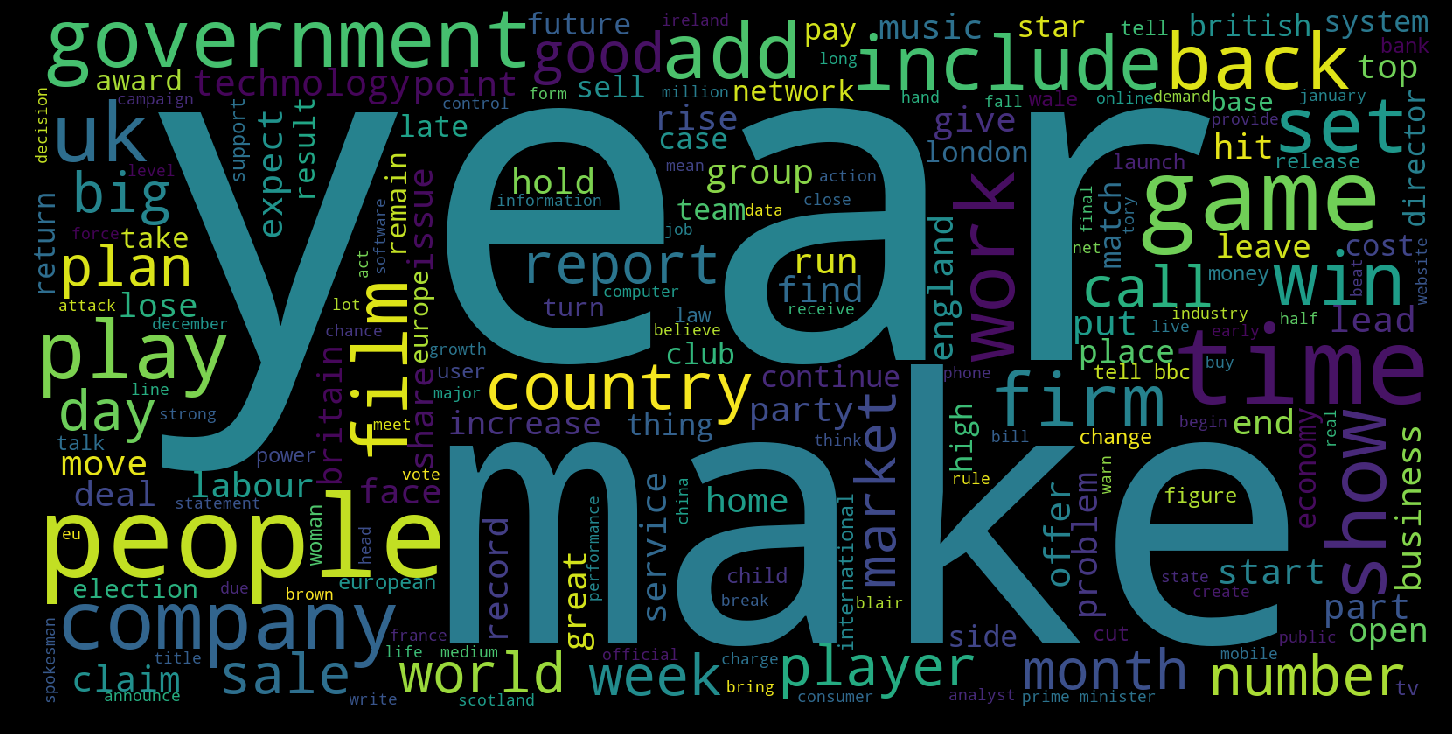

In [22]:
joined_tokens = [token for document in df_handle["Tokens"] for token in document]

#saves wordcloud of all tokens as file. Please note, this word cloud is for all tokens not just noun tokens
wordcloudplot(joined_tokens, 'img_wordcloud1.png')

Looking at our word cloud, we can see immediately that a lot of verbs are present, this will not necessarily help us with our classification step and so this influenced us to look at noun and adjective tokens instead, going forward.

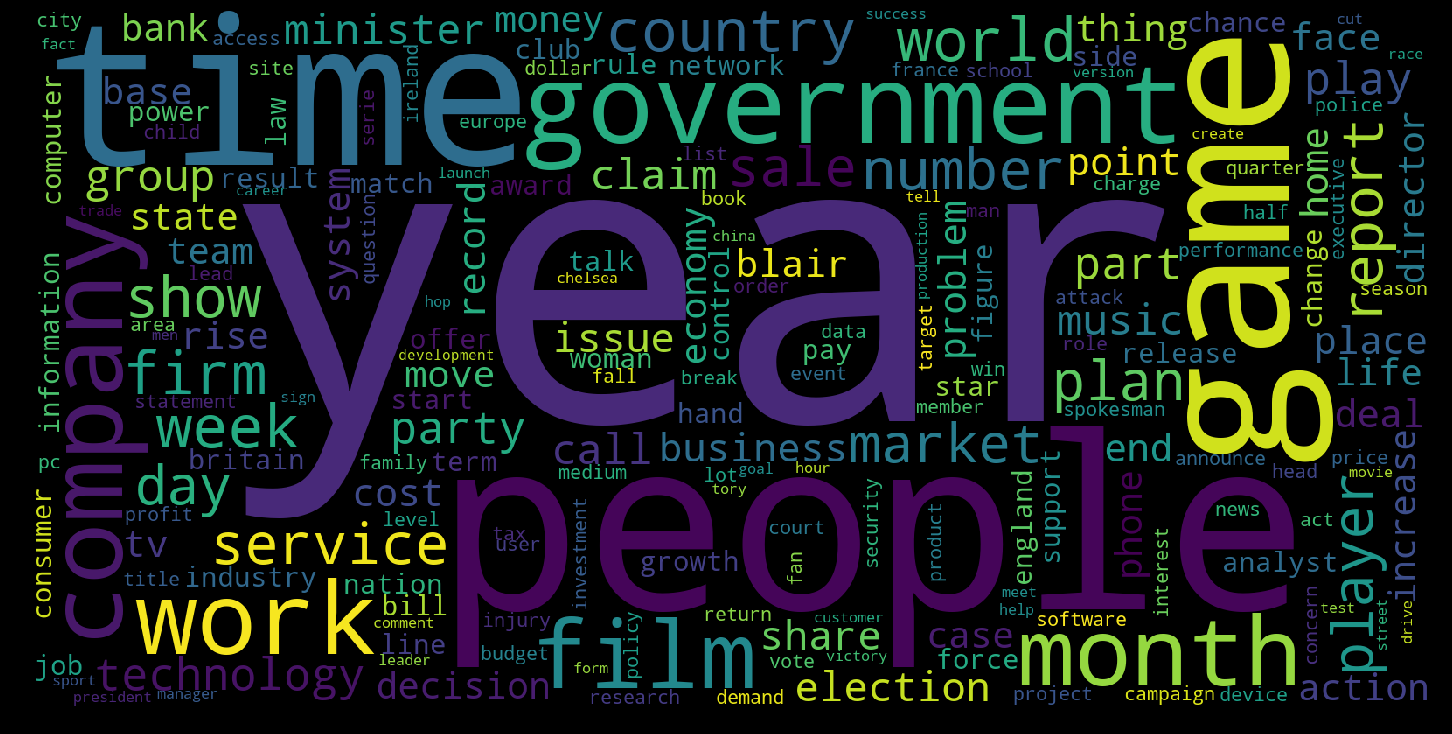

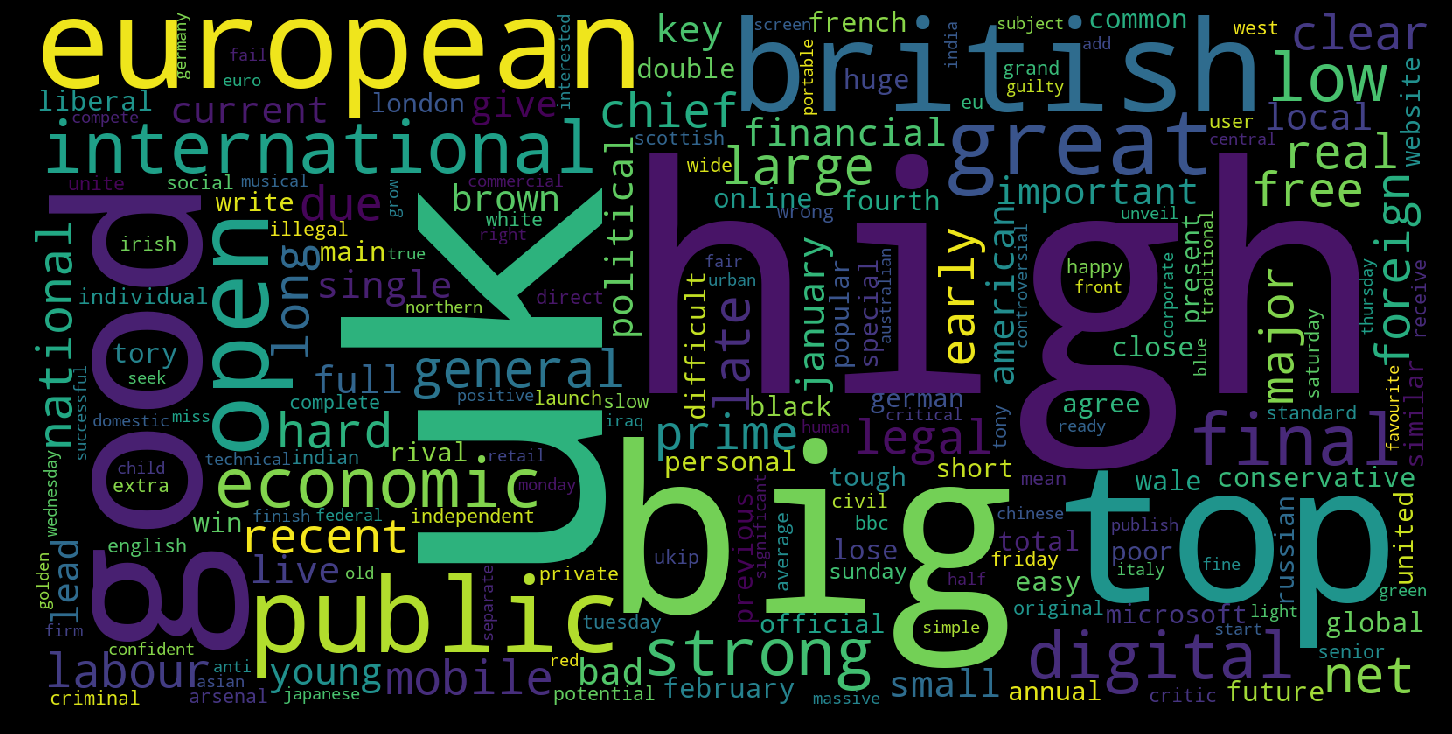

In [23]:
noun_tokens = [token for document in df_handle["noun_tokens"] for token in document]
adjective_tokens = [token for document in df_handle["adjective_tokens"] for token in document]
wordcloudplot(noun_tokens, 'img_wordcloud2.png')
wordcloudplot(adjective_tokens, 'img_wordcloud3.png')

### Frequency

With that in mind, we wanted to look at the frequency of certain nouns and adjectives overall in the data with hopes that we could glean some information to aid classification.

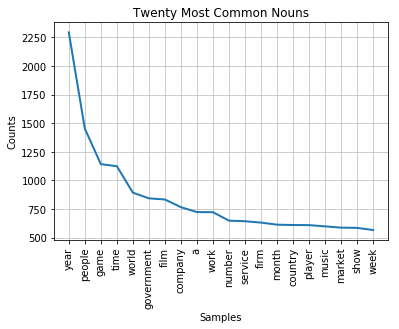

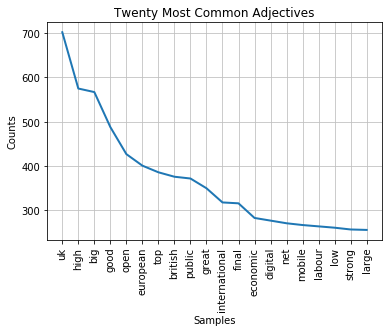

In [24]:
joined_noun_tokens = [token for document in df_handle["noun_tokens"] for token in document]
word_frequency = nltk.FreqDist(joined_noun_tokens)
word_frequency.plot(20, title='Twenty Most Common Nouns')

joined_adjective_tokens = [token for document in df_handle["adjective_tokens"] for token in document]
word_frequency = nltk.FreqDist(joined_adjective_tokens)
word_frequency.plot(20, title='Twenty Most Common Adjectives')

The nouns looks pretty useful with words like government, film, and game all likely being high indicators as to the category of the data. On the other hand, the adjectives seem much less useful with words like high, big, and good being so prevalent.

# Analysis

## Step 4 : Most Common Bigrams and Trigrams

Another part of our analysis involved looking at bigrams and trigrams, which in turn will be a huge help to us when it comes to classification.

### Bigrams

In [25]:
joined_tokens = [token for document in df_handle["Tokens"] for token in document]

bigram = ngrams(joined_tokens, 2)
bi_frequencies = nltk.FreqDist(bigram)
dict_items =list(dict(bi_frequencies).items())
#make a dataframe of the bigrams and their frequencies
df_bigramFreq = pd.DataFrame(dict_items, columns=['bigram','freq']).sort_values(by='freq', ascending=False)
df_bigramFreq = df_bigramFreq.reset_index(drop=True)
#show only top five
df_bigramFreq.head(5)

,bigram,freq
0,"(tell, bbc)",244
1,"(prime, minister)",230
2,"(chief, executive)",138
3,"(year, ago)",127
4,"(tony, blair)",127


In [26]:
# Function to check the gram is noun gram or not
def IsNounGram(ngram):
    if ('-pron-' in ngram) or ('t' in ngram):
        return False
    
    first_type = ('JJ','JJR','JJS','NN','NNS','NNP','NNPS')
    second_type = ('NN','NNS','NNP','NNPS')
    tags = nltk.pos_tag(ngram,lang='eng')
    if (tags[0][1] in first_type) and (tags[1][1] in second_type):
        return True
    else:
        return False

In [27]:
##look only at top 50 for efficiency sake
df_bigramFreq_filter = df_bigramFreq.copy().head(50)
#creaete a new column which check for each bigram, which are noun grams , returns true or false
df_bigramFreq_filter['noun_gram'] = df_bigramFreq_filter["bigram"].map(lambda x : IsNounGram(x))
#filter out those that are false
df_bigramFreq_filter = df_bigramFreq_filter[df_bigramFreq_filter.noun_gram != False]
df_bigramFreq_filter.head(5)

,bigram,freq,noun_gram
0,"(tell, bbc)",244,True
1,"(prime, minister)",230,True
2,"(chief, executive)",138,True
4,"(tony, blair)",127,True
5,"(bbc, news)",123,True


We can see from this that our top five have changed a little (as has the entire dataframe). We were concerned with the (tell, BBC) bigram, and so decided that we needed to add an additional step of checking that this appeared in the text.

In [28]:
##check that these ngrams actually appear together in the text!
def CheckWordInText(word, Text):
    if word in Text.lower():
        return True
    else:
        return False

In [29]:
#combine all texts
full_corpus =' '.join([document for document in df_handle["content"]])
# combine all the tokens
for index, row in df_handle.iterrows():
    full_corpus = full_corpus + df_handle['content'].iloc[index]

In [32]:
##Note this next cell is taking FOREVER, anyone have an alternative?
#Jeremy: Does not seem terrible runtime to me, perhaps fixed when I fixed the above?

In [30]:
df_real_bigram = df_bigramFreq_filter.copy()

#true if exists
exists_list = []
for index, row in df_bigramFreq_filter.iterrows():
    gram = row['bigram']
    word = (' '.join(gram))
    exists_list.append(CheckWordInText(word, full_corpus))

#create new column for these    
df_bigramFreq_filter['exist'] = exists_list    

#delete those that are false
df_real_bigram = df_bigramFreq_filter[df_bigramFreq_filter.exist != False]

#show top 5
df_real_bigram.head(5)

,bigram,freq,noun_gram,exist
1,"(prime, minister)",230,True,True
2,"(chief, executive)",138,True,True
4,"(tony, blair)",127,True,True
5,"(bbc, news)",123,True,True
6,"(general, election)",119,True,True


We shall now do the same for trigrams. We decided to go no higher than n = 3, for the purposes of this corpus. WHY???

### Trigrams

In [31]:
joined_tokens = [token for document in df_handle["Tokens"] for token in document]
trigram = ngrams(joined_tokens, 3)
tri_frequencies = nltk.FreqDist(trigram)
dict_items = list(dict(tri_frequencies).items())
#make a dataframe of the trigrams and their frequencies
df_trigramFreq = pd.DataFrame(dict_items, columns=['trigram','freq']).sort_values(by='freq', ascending=False)
df_trigramFreq = df_trigramFreq.reset_index(drop=True)

#check for noun grams
##look only at top 50 for efficiency sake
df_trigramFreq_filter = df_trigramFreq.copy().head(50)
#creaete a new column which check for each bigram, which are noun grams , returns true or false
df_trigramFreq_filter['noun_gram'] = df_trigramFreq_filter["trigram"].map(lambda x : IsNounGram(x))
#filter out those that are false
df_trigramFreq_filter = df_trigramFreq_filter[df_trigramFreq_filter.noun_gram != False]
#printf(df_bigramFreq_filter.head(5))

#check in text
df_real_trigram = df_trigramFreq_filter.copy()

exits_list = []
for index, row in df_trigramFreq_filter.iterrows():
    gram = row['trigram']
    word = (' '.join(gram))
    exits_list.append(CheckWordInText(word, full_corpus))
    
df_real_trigram['exist'] = exits_list
df_real_trigram = df_real_trigram.loc[df_real_trigram.exist==True]


#df_trigramFreq_filter.head(5)
df_real_trigram.head(5)

,trigram,freq,noun_gram,exist
1,"(bbc, news, website)",63,True,True
3,"(leader, michael, howard)",40,True,True
8,"(tory, leader, michael)",28,True,True
9,"(chancellor, gordon, brown)",24,True,True
10,"(leader, charles, kennedy)",21,True,True


Comments on this....

# Vectorization

## Step 5: Vectorising the training set

Take a subset of the training set to test later functions

In [33]:
#the sample output given shows only zeros but it is working
merged_tokens = [" ".join(x) for x in df_handle["noun_tokens"]]
tfidf_vectorizer = TfidfVectorizer(norm=None)
tfidf_train = pd.DataFrame(tfidf_vectorizer.fit_transform(merged_tokens).todense(), columns = tfidf_vectorizer.get_feature_names())
tfidf_train.head(5)

,aa,aaa,aaas,aac,aadc,aaliyah,aamir,aan,aarhus,aaron,...,zone,zonealarm,zoom,zooropa,zornotza,zubair,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 6: Vectorising the test set

In [34]:
test_clean_data = [" ".join(x) for x in df_handle_test.Tokens]

# Create a tfidf for the test data with the same dimensions (i.e. headers)
# as the set above. necessary for comparing models
tfidf_clean = tfidf_vectorizer.transform(test_clean_data)
## For printing that tf-idf matrix, we convert it into dataframe
tfidf_test = pd.DataFrame(tfidf_clean.toarray(),columns=[tfidf_vectorizer.get_feature_names()])
tfidf_test.head(5)

,aa,aaa,aaas,aac,aadc,aaliyah,aamir,aan,aarhus,aaron,...,zone,zonealarm,zoom,zooropa,zornotza,zubair,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Learning

## Step 7: Class Analysis

In [35]:
labels_train = df_handle['category']

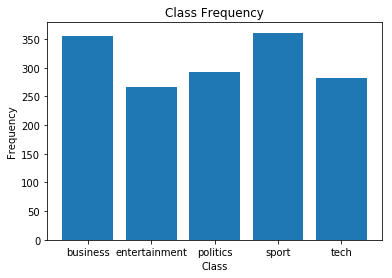

In [36]:
import matplotlib.pyplot as plt

unique, counts = np.unique(labels_train, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

From this plot we can see this is a balanced dataset

## Step 8: Select Classifiers

### K Cross Fold Validation

In [37]:
validation_size = 0.1
num_folds = 10
model_tfidf, validation_tfidf, model_labels, validation_labels = train_test_split(tfidf_train, labels_train, test_size=validation_size, shuffle=True, stratify=labels_train)

### BAYES classifier

In [39]:
modelbayes = MultinomialNB()
modelbayes.fit(model_tfidf, model_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### KNN classifier

In [40]:
#takes about 5-6 mins to complete
k_values = [1,2]
print("the range of k is " + str(k_values))
grid_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':k_values}, scoring='accuracy', cv = num_folds)
grid_search.fit(model_tfidf, model_labels)

the range of k is [1, 2]


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [41]:
modelknn = KNeighborsClassifier(**grid_search.best_params_)
modelknn.fit(model_tfidf, model_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

According to this subset, the best value is k=1

### Logistic classifier

In [42]:
c_values = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2]
grid_search = GridSearchCV(LogisticRegression(), {'C':c_values}, scoring='accuracy', cv = num_folds)
grid_search.fit(model_tfidf, model_labels)

modellr = LogisticRegression(**grid_search.best_params_)
modellr.fit(model_tfidf, model_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Step 9: Applying models to test set to estimate accuracy

In [43]:
predicted_labels_bayes = modelbayes.predict(validation_tfidf)
predicted_probas_bayes = modelbayes.predict_proba(validation_tfidf)

In [44]:
predicted_labels_knn = modelknn.predict(validation_tfidf)
predicted_probas_knn = modelknn.predict_proba(validation_tfidf)

In [45]:
predicted_labels_lr = modellr.predict(validation_tfidf)
predicted_probas_lr = modellr.predict_proba(validation_tfidf)

In [46]:
Acc_bayes = accuracy_score(validation_labels, predicted_labels_bayes)
print('Accuracy rate for NB model: {:0.2f}%'.format(Acc_bayes*100))

Accuracy rate for NB model: 99.36%


In [49]:
Acc_knn = accuracy_score(validation_labels, predicted_labels_knn)
print('Accuracy rate for KNN model: {:0.2f}%'.format(Acc_knn*100))

Accuracy rate for KNN model: 76.92%


In [47]:
Acc_lr = accuracy_score(validation_labels, predicted_labels_lr)
print('Accuracy rate for Logistic model: {:0.2f}%'.format(Acc_lr*100))

Accuracy rate for Logistic model: 99.36%


# Step 10: Evaluation and Results

We chose Log Loss as our evaluation metric

In [48]:
log_loss_bayes = log_loss(validation_labels, predicted_probas_bayes)
print('Error rate for Logistic model using Log Loss evaluation metric: {:0.2f}%'.format(log_loss_bayes*100))

Error rate for Logistic model using Log Loss evaluation metric: 22.14%


In [50]:
# there's a problem here something about the dimension of the probability matrix, tried normalising, didn't fix it
log_loss_knn = log_loss(validation_labels, predicted_probas_knn)
print('Error rate for Logistic model using Log Loss evaluation metric: {:0.2f}%'.format(log_loss_knn*100))

Error rate for Logistic model using Log Loss evaluation metric: 797.05%


In [51]:
log_loss_lr = log_loss(validation_labels, predicted_probas_lr)
print('Error rate for Logistic model using Log Loss evaluation metric: {:0.2f}%'.format(log_loss_lr*100))

Error rate for Logistic model using Log Loss evaluation metric: 81.22%


In both tests, Bayes seems to perform the best

# Step 11: Applying Model to Test Set

In [52]:
predicted_labels_bayes = modelbayes.predict(tfidf_test)
predicted_probas_bayes = modelbayes.predict_proba(tfidf_test)
type(predicted_labels_bayes)

numpy.ndarray

In [53]:
df_handle_test_onhold["Predicted Labels"] = predicted_labels_bayes
df_handle_test_onhold

,content,Predicted Labels
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech
5,US Airways staff agree to pay cut A union repr...,business
6,Blunkett row should end - Blair Prime Minister...,politics
7,Nasdaq planning $100m share sale The owner of ...,business
8,Gallery unveils interactive tree A Christmas t...,entertainment
9,Escaped prisoner report ordered First Minister...,politics


Looks pretty good tbh, great work everyone. Still plenty to do though!